In [1]:
## 数据工具包
import numpy as np
np.random.seed(42)
import pandas as pd
from tqdm import tqdm

## 字符串处理工具包
import string
import re
import gensim
from collections import Counter
import pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.preprocessing import text, sequence 

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from functools import partial

import os 
import gc
from scipy.sparse import vstack  
import time
import datetime

import joblib

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns 
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = './input/'

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train = pd.read_csv(path+'train.csv', usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+'test.csv', usecols=test_columns, dtype=dtypes)

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   click_id    uint32
 1   ip          uint32
 2   app         uint16
 3   device      uint16
 4   os          uint16
 5   channel     uint16
 6   click_time  object
dtypes: object(1), uint16(4), uint32(2)
memory usage: 430.1+ MB


In [4]:
print(train.shape, test.shape)

(184903890, 7) (18790469, 7)


In [5]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [7]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ip             uint32
 1   app            uint16
 2   device         uint16
 3   os             uint16
 4   channel        uint16
 5   click_time     object
 6   is_attributed  uint8 
dtypes: object(1), uint16(4), uint32(1), uint8(1)
memory usage: 3.6+ GB


<Figure size 432x288 with 0 Axes>

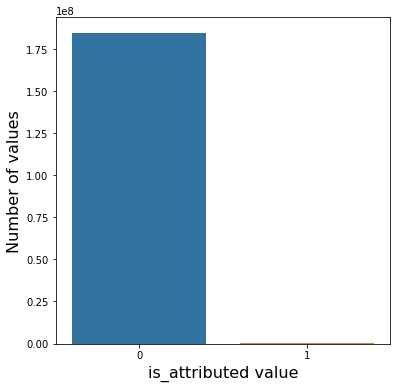

In [9]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = train['is_attributed'].value_counts().index.values
y = train["is_attributed"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=16)
plt.xlabel('is_attributed value', fontsize=16)
plt.savefig("标签分布.svg", format="svg")

In [10]:
train['is_attributed'].value_counts(normalize=True)

0    0.997529
1    0.002471
Name: is_attributed, dtype: float64

<Figure size 432x288 with 0 Axes>

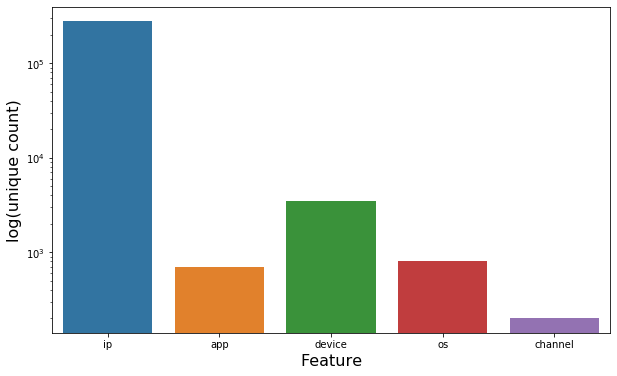

In [11]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.barplot(ax=ax, x=cols, y=uniques, log=True)
plt.ylabel('log(unique count)', fontsize=16)
plt.xlabel('Feature', fontsize=16)
plt.savefig("取对数后unique个数展示.svg", format="svg")

## 单变量分析

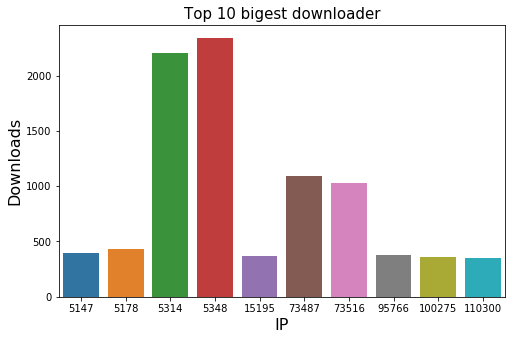

In [12]:
tmp = train.groupby('ip').is_attributed.sum()
data_plot = tmp.nlargest(10).reset_index()
data_plot.columns=('IP', 'Downloads')
data_plot.sort_values('Downloads', ascending = False)
plt.figure(figsize = (8,5))
sns.barplot(x = data_plot['IP'], y = data_plot['Downloads'])
plt.ylabel('Downloads', fontsize=16)
plt.xlabel('IP', fontsize=16)
plt.title('Top 10 bigest downloader', fontsize = 15)
plt.savefig("下载量最高的10个IP.svg", format="svg")

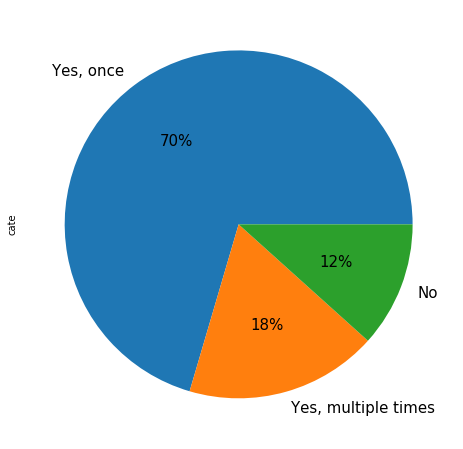

In [13]:
data_plot = pd.DataFrame(tmp).reset_index()

data_plot["cate"] = ''
data_plot.loc[data_plot['is_attributed'] == 0, "cate"] = "No"
data_plot.loc[data_plot['is_attributed'] == 1, "cate"] = "Yes, once"
data_plot.loc[data_plot['is_attributed'] > 1, "cate"] = "Yes, multiple times"

plt.figure(figsize=(8,8))
data_plot["cate"].value_counts().plot(kind = 'pie',autopct='%1.0f%%', fontsize = 15)
plt.savefig("下载量分类占比.svg", format="svg")

In [14]:
train['day'] = pd.to_datetime(train.click_time).dt.day
train['hour'] = pd.to_datetime(train.click_time).dt.hour

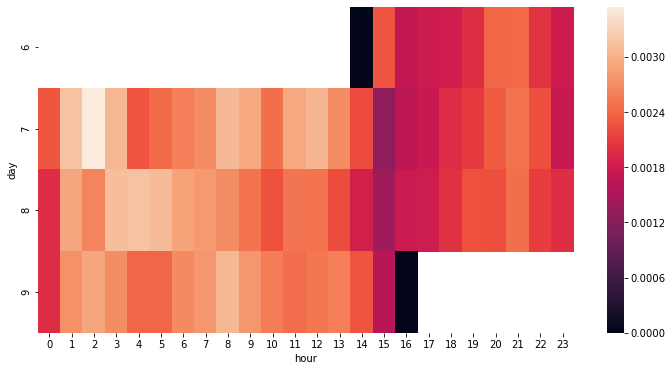

In [15]:
grouped_df = train.groupby(["day", "hour"])["is_attributed"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_attributed')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.savefig("不同时刻下载率展示.svg", format="svg")

In [16]:
train = train.loc[train['day'].isin([7,8])]

In [17]:
train['day'].value_counts()

8    62945075
7    59633310
Name: day, dtype: int64

<Figure size 432x288 with 0 Axes>

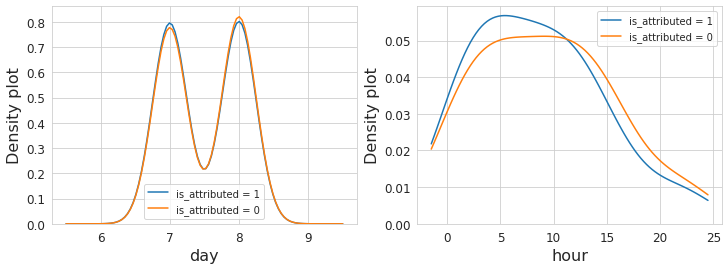

In [18]:
cols = ['day','hour']

i = 0
train1 = train.loc[train['is_attributed'] != 0]
train0 = train.loc[train['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))

for col in cols:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(train1[col], bw=0.5,label="is_attributed = 1")
    sns.kdeplot(train0[col], bw=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=16)
    plt.xlabel(col, fontsize=16)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("不同时刻正负样本的密度分布图.svg", format="svg")

In [19]:
train.loc[train['is_attributed'] != 0]['hour'].value_counts(normalize=True)

2     0.066972
3     0.064808
4     0.064059
1     0.063535
12    0.058654
11    0.058343
5     0.057888
13    0.055044
7     0.054893
8     0.054670
9     0.053636
6     0.052965
10    0.051888
0     0.049577
14    0.045037
23    0.028839
15    0.027212
16    0.026784
22    0.017310
17    0.015376
18    0.009935
21    0.008707
19    0.007447
20    0.006419
Name: hour, dtype: float64

In [20]:
train.loc[train['is_attributed'] == 0]['day'].value_counts(normalize=True)

8    0.513538
7    0.486462
Name: day, dtype: float64

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

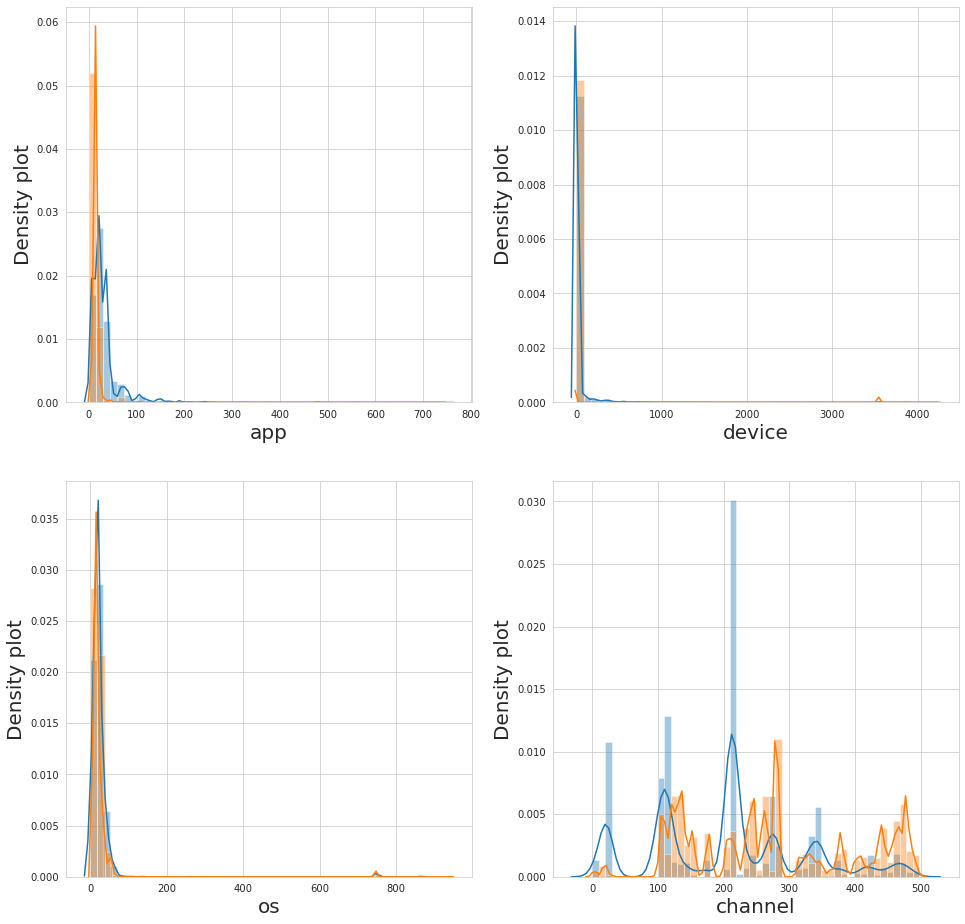

In [21]:
cols = ['app','device','os','channel']

train1 = train[train['is_attributed'] == 1][train['day'] == 8]
train0 = train[train['is_attributed'] == 0][train['day'] == 8]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(16,16))

i = 0
for col in cols:
    i += 1
    plt.subplot(2,2,i)
    sns.distplot(train1[col], label="is_attributed = 1")
    sns.distplot(train0[col], label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=20)
    plt.xlabel(col, fontsize=20)
plt.savefig("单变量正负样本密度分布图.svg", format="svg")

## 多变量分析

In [22]:
def groupby_count( df, group_cols, agg_name):

    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    df[agg_name] = df[agg_name].astype('uint32')
    
    return df

train = groupby_count(train, ['ip', 'day', 'hour'], 'ip_day_hour_count')
train = groupby_count(train, ['ip', 'app'], 'ip_app_count')
train = groupby_count(train, ['ip', 'app', 'os'], 'ip_app_os_count')
train = groupby_count(train, ['ip', 'day', 'channel'], 'ip_day_channel_count')

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: Use

<Figure size 432x288 with 0 Axes>

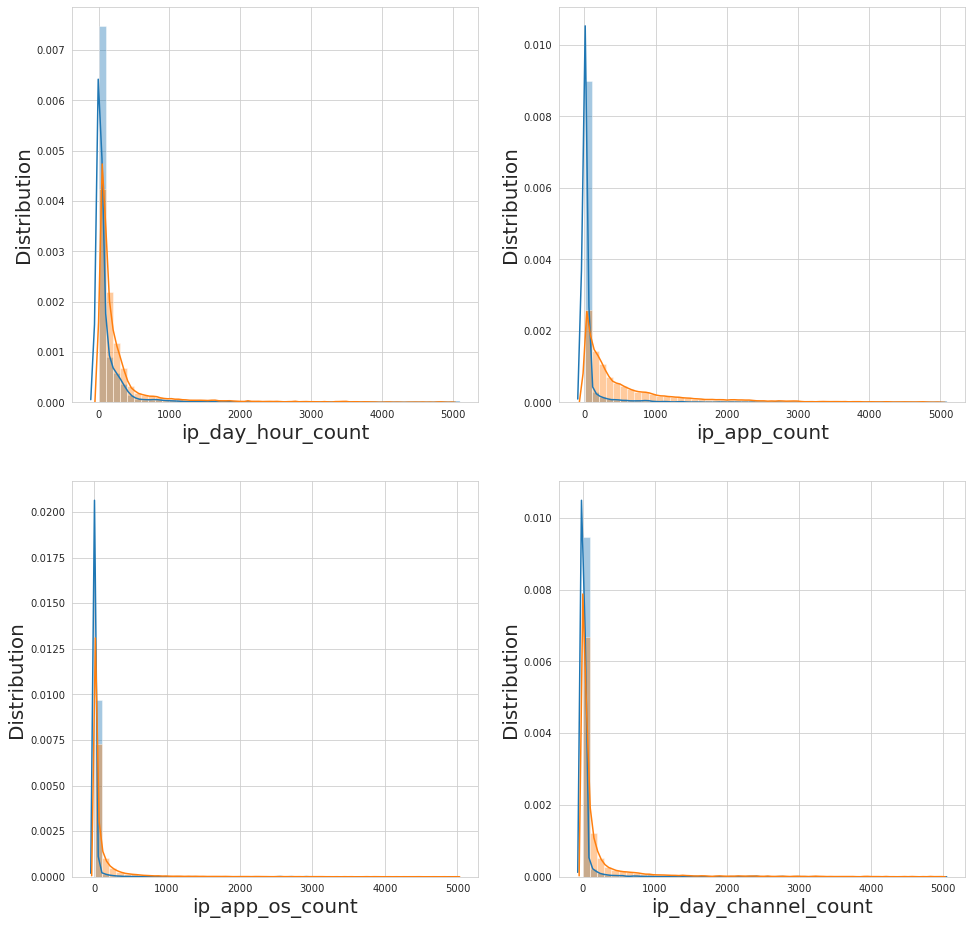

In [24]:
cols = ['ip_day_hour_count','ip_app_count','ip_app_os_count','ip_day_channel_count']

train1 = train[train['is_attributed'] == 1][train['day'] == 8]
train0 = train[train['is_attributed'] == 0][train['day'] == 8]

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,2,figsize=(16,16))
i = 0
for col in cols:
    i = i + 1
    plt.subplot(2,2,i)
    sns.distplot(train1[train[col] < 5000][col], label="is_attributed = 1")
    sns.distplot(train0[train[col] < 5000][col], label="is_attributed = 0")
    plt.ylabel('Distribution', fontsize=20)
    plt.xlabel(col, fontsize=20)
plt.savefig("多变量组合后正负样本密度分布.svg", format="svg")

## 数据分布

<Figure size 432x288 with 0 Axes>

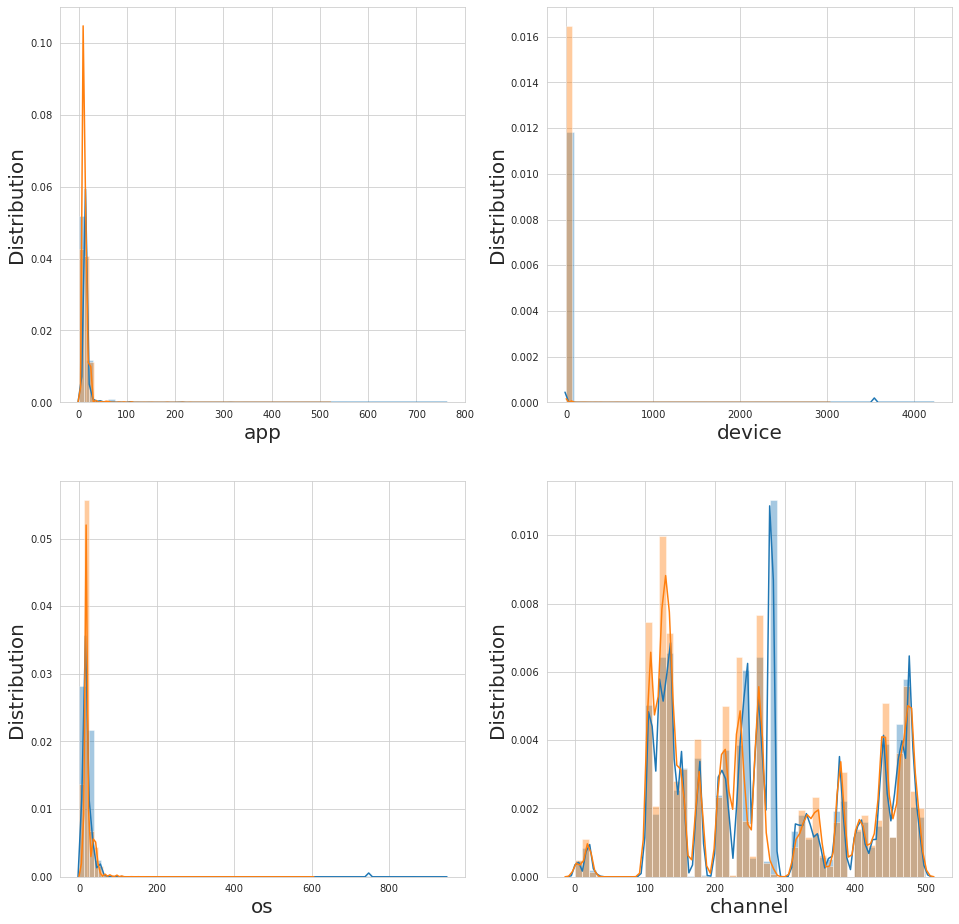

In [25]:
cols = ['app','device','os','channel']

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(2,2,figsize=(16,16))
i = 0
for col in cols:
    i = i + 1
    plt.subplot(2,2,i)
    sns.distplot(train.loc[train.day==8, col], label="train")
    sns.distplot(test[col], label="test")
    plt.ylabel('Distribution', fontsize=20)
    plt.xlabel(col, fontsize=20)
plt.savefig("训练集和测试集的变量密度分布.svg", format="svg")

In [26]:
test['day'] = pd.to_datetime(test.click_time).dt.day
test['hour'] = pd.to_datetime(test.click_time).dt.hour

In [27]:
train['day'].value_counts()

8    62945075
7    59633310
Name: day, dtype: int64

<Figure size 432x288 with 0 Axes>

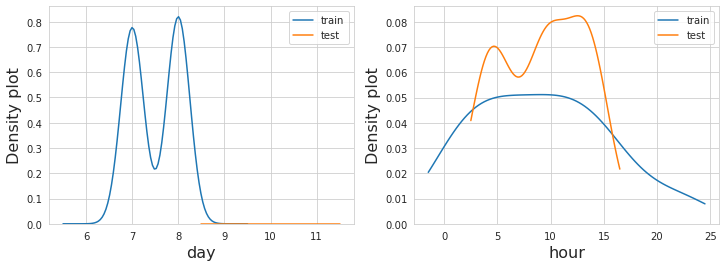

In [28]:
cols = ['day','hour']

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))
i = 0
for col in cols:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(train[col], bw=0.5, label="train")
    sns.kdeplot(test[col], bw=0.5, label="test")
    plt.ylabel('Density plot', fontsize=16)
    plt.xlabel(col, fontsize=16)
plt.savefig("训练集和测试集的day和hour密度分布.svg", format="svg")